# Imports 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Data

In [ ]:
marketing = pd.read_csv("./Data/data_cleaned.csv",index_col=0,parse_dates=['date_served','date_subscribed','date_canceled'])

In [ ]:
marketing.head(3)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,is_correct_lang
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0,Yes
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0,Yes
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0,Yes


# Notes

**A/B Testing** tests the impact of a decision on a particular metric 

Procedure:

1. Determine hypothesis and the desired outcome of the test (increase conversion rates by personalizing emails)

2. What is the metric you're trying to impact? 

3. Will we get enough traffic to our site to reach statistical significance and make a decision in a timely manner 

The email portion of this campaign was actually run as an A/B test. Half the emails sent out were generic upsells to your product while the other half contained personalized messaging around the users’ usage of the site.

The **Lift** is the percentage increase in conversion (any metric) of the treatment vs the control i.e. (treat conv - contr conv)/(contr conv)

# Test Allocation

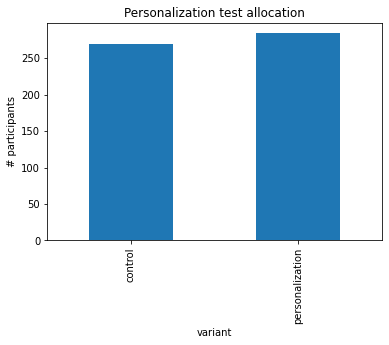

In [ ]:
# Subset the DataFrame
email = marketing[marketing.marketing_channel == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby('variant')['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

There is a slight difference in allocation but its within reason (is explained by randomness). There is a statistical test that should be run to check this

# Compare Conversion Rates

In [ ]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', control.mean())
print('Personalization conversion rate:', personalization.mean())

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


## Lift

In [ ]:
def lift(a,b):
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean - a_mean)/(a_mean)
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


## Run t-test

In [ ]:
from scipy import stats

In [ ]:
stats.ttest_ind(control,personalization)

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.006451487844694175)

Hence, the difference is significant -> **Personalized Ads increased conversion rates**

# Repeat analysis across segments (language and age group)

In [ ]:
def ab_segmentation(segment):
  # Build a for loop for each subsegment in marketing
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control,personalization)) 
      print('t-statistic:', stats.ttest_ind(control,personalization), '\n\n')

## Language

In [ ]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815) 


German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678) 


Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




## Age Group

In [ ]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226) 


19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134) 


24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 


30-36 years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137) 


36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.4317901279318503, pvalue=0.01797568600978829) 


45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196) 


55+ years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435) 




Personalization was **significantly effective for younger age groups** and actually **lowered conversion rates for older age groups** 